In [1]:
import numpy as np
import random
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

In [3]:
##Data split: users
k = 15

users = ratings.user_id.unique()
items = ratings.movie_id.unique()
n_items = len(items)
n_users = len(users)

train_users = random.sample(users,660)
mask = ratings['user_id'].isin(train_users)

train_ratings = ratings.loc[mask]
test_ratings = ratings.loc[~mask]

print train_ratings.shape
print test_ratings.shape



(71321, 4)
(28679, 4)


In [4]:
user_films = {}

for user in train_users:
    rated_films = train_ratings['movie_id'].loc[train_ratings['user_id'] == user]
    user_films[user] = list(rated_films.values)


In [5]:
#Initialise
sig_p = 0.1
sig = 1
lamda_p = sig/sig_p

param_items = {}
param_users = {}

for item in items:
    param_items[item] = [ np.zeros(k) , np.identity(k)*sig_p]

for user in users:
    param_users[user] = [ np.zeros(k) , np.identity(k)*sig_p]
    


In [6]:
#Train

T = 10
X=0.01*np.identity(k)
for user in train_users:
    A = np.identity(k)*lamda_p
    b = np.zeros((k,1))
    for _ in range(1,T):
#         try:
#             i = np.linalg.svd(A)
#             i = np.linalg.inv(A)
#         except np.linalg.LinAlgError as err:
#             print('error_A')
#             print(A)
#             break;
        
        param_users[user] = [np.matmul(np.linalg.inv(A),b), np.linalg.inv(A)*sig ]
        p_u = np.random.multivariate_normal(param_users[user][0].reshape((k,)),param_users[user][1])
        
        item_star = 0
        q_star = 0
        reward_dot = float('-inf')
        
        #Get a q
        random.shuffle(user_films[user])
        for item in user_films[user]:
            q_i = np.random.multivariate_normal(param_items[item][0].reshape((k,)),param_items[item][1])
            r = np.matmul(p_u.T,q_i)+ 0.03*pow(np.matmul(np.matmul(q_i.T,param_items[item][1]),q_i),0.5)
            if (r > reward_dot):
                reward_dot = r
                item_star = item
                q_star = q_i
        

        Actual_reward = ratings['rating'].loc[(ratings['user_id'] == user) &
                                                      (ratings['movie_id'] == item)].values
        
        #User Updates
        q_star = q_star.reshape((k,1))
        A = A+ np.matmul(q_star,q_star.T)
#         A = A/np.linalg.norm(A)
        b = b+ Actual_reward*q_star
#         b = b/np.linalg.norm(b)
        
        #Item Updates
        C = param_items[item_star][1]/sig
        
#         try:
#             i = np.linalg.inv(C)
#         except np.linalg.LinAlgError as err:
#             print('error_Cx')
#             break;
        
        
        p_u = p_u.reshape((k,1))
        C = np.linalg.inv(C)
        d = np.matmul(C,param_items[item_star][0])
        C = C+ np.matmul(p_u,p_u.T)
#         C = C/np.linalg.norm(C)
        d = d+ Actual_reward*p_u.reshape((k,))
#         d = d/np.linalg.norm(d)
        
#         try:
#             i = np.linalg.inv(C)
#             i = np.linalg.svd(C)
#         except np.linalg.LinAlgError as err:
#             print('error')
#             print(C)
#             continue;

        
        param_items[item] = [np.matmul(np.linalg.inv(C),d), np.linalg.inv(C)*sig]
        user_films[user].remove(item_star)

            
            
        
        


In [15]:
test_users= np.setdiff1d(users,train_users)
test_user_films = {}

for user in test_users:
    test_rated_films = test_ratings['movie_id'].loc[test_ratings['user_id'] == user]
    test_user_films[user] = list(test_rated_films.values)

#Initialize new users
test_users_top10={}
#Learn test user features
hits={}
for user in test_users[:10]:
    hits[user]=0
    A = np.identity(k)*lamda_p
    b = np.zeros((k,1))
    for _ in range(1,T):

        param_users[user] = [np.matmul(np.linalg.inv(A),b), np.linalg.inv(A)*sig ]
        p_u = np.random.multivariate_normal(param_users[user][0].reshape((k,)),param_users[user][1])
        
        item_star = 0
        q_star = np.zeros((k,1))
        reward_dot = float('-inf')
        
        #Get a q
        random.shuffle(test_user_films[user])
        for item in test_user_films[user]:
            q_i = np.random.multivariate_normal(param_items[item][0].reshape((k,)),param_items[item][1])
            r = np.matmul(p_u.T,q_i)+0.03*pow(np.matmul(np.matmul(q_i.T,param_items[item][1]),q_i),0.5)
            if (r > reward_dot):
                reward_dot = r
                item_star = item
                q_star = q_i
        

        Actual_reward = ratings['rating'].loc[(ratings['user_id'] == user) &
                                                      (ratings['movie_id'] == item)].values
        test_user_films[user].remove(item_star)
        #check for hits 
        if (Actual_reward>3):
            hits[user]+=1
        
        #User Updates
        q_star = q_star.reshape((k,1))
        A = A+ np.matmul(q_star,q_star.T)
        b = b+ Actual_reward*q_star
    
    temp_items= []
    for item in items:
        q_i = np.random.multivariate_normal(param_items[item][0].reshape((k,)),param_items[item][1])
        Actual_reward = ratings['rating'].loc[(ratings['user_id'] == user) &
                                                      (ratings['movie_id'] == item)].values
        if len(Actual_reward)==0:
            Actual_reward = None
        r = np.matmul(p_u.T,q_i)
        temp_items.append([r,item,Actual_reward])
    from operator import itemgetter
    temp_items=sorted(temp_items , key= itemgetter(0))
    test_users_top10[user]=temp_items[0:10] 
      

In [20]:
print test_users_top10[test_users[8]]


[[-3.9409726130631446, 7, array([4])], [-3.9111156642287286, 173, array([3])], [-3.825029271806814, 294, array([1])], [-3.770504701881484, 269, None], [-3.755096828756895, 100, array([4])], [-3.7531015979287297, 22, None], [-3.736519599145703, 346, array([4])], [-3.6742521204066927, 1299, None], [-3.6719673569070284, 1190, None], [-3.668543913648719, 613, None]]


In [196]:
print hits[user]

8


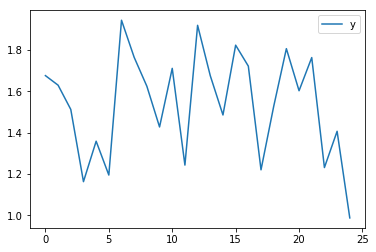

In [127]:
x=np.zeros(25)
y=np.zeros(25)
ind=np.linspace(0,24,25)
for i in range (0,25):
    j = train_users[i]
    x[i]=np.linalg.norm(param_users[j][0])
    y[i]=np.linalg.norm(param_users[j][0])
# plt.plot(ind,x,label='x')
plt.plot(ind,y,label='y')
plt.legend()
plt.show()

'1.14.3'